# Unsupervised and supervised archetype analysis on combined dataset (raw and scanorama)

In [1]:
# import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import dropkick as dk
import mazebox as mb
import cellrank as cr
import scanorama
from scipy.spatial.distance import squareform
from scipy.sparse import issparse, csr_matrix, find
from scipy.spatial.distance import pdist
from py_pcha import PCHA
from sklearn.utils import shuffle
from matplotlib.colors import CenteredNorm

In [2]:
adata = sc.read_h5ad('../../data/combined/adata_01_filtered.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 8908 × 16719
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'sample_x', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample_y', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_s

## MAGIC

For stronger PCHA, we'll run MAGIC.

In [4]:
import magic
# import pandas as pd
# import matplotlib.pyplot as plt
magic_operator = magic.MAGIC(solver='approximate')
X_magic = magic_operator.fit_transform(adata)


Calculating MAGIC...
  Running MAGIC on 8908 cells and 16719 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 6.44 seconds.
    Calculating KNN search...
    Calculated KNN search in 10.47 seconds.
    Calculating affinities...
    Calculated affinities in 12.51 seconds.
  Calculated graph and diffusion operator in 29.47 seconds.
  Calculating imputation...
  Calculated imputation in 0.07 seconds.
Calculated MAGIC in 33.55 seconds.


In [5]:
sc.pp.pca(X_magic)

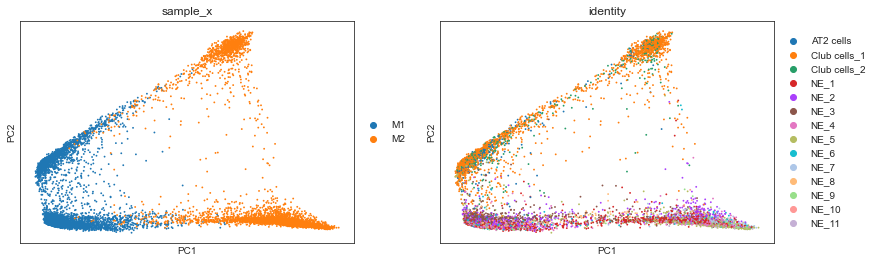

In [6]:
sc.pl.pca(X_magic, color=['sample_x','identity'])

In [7]:
scv.pp.neighbors(X_magic, random_state=0)
scv.tl.umap(X_magic, random_state=0)

computing neighbors


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


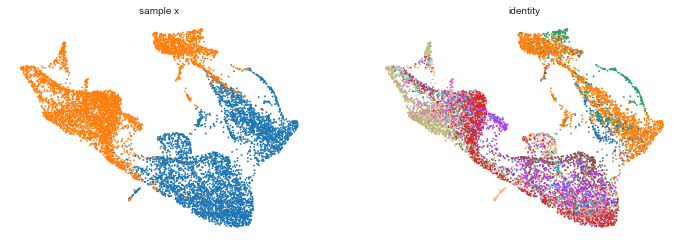

In [8]:
scv.pl.umap(X_magic,color=['sample_x','identity'])

In [9]:
X_magic

AnnData object with n_obs × n_vars = 8908 × 16719
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'sample_x', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample_y', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_s

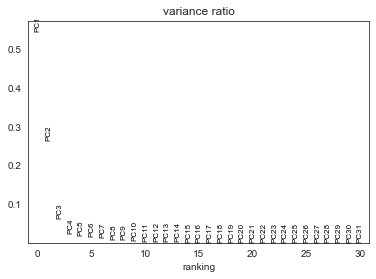

In [10]:
sc.pl.pca_variance_ratio(X_magic)

In [11]:
pca_var = X_magic.uns['pca']['variance_ratio']
var_explained = .90
tot_exp_var = 0
n = 0
for i in pca_var:
    n +=1
    tot_exp_var += i
    if tot_exp_var > var_explained: 
        print(n+1, "PCs explain at least", var_explained*100, "percent of the variance")
        break

6 PCs explain at least 90.0 percent of the variance


In [12]:
def cumulative(var):
    cum_var = []
    tot_sum = 0
    for i in var:
        tot_sum += i
        cum_var.append(tot_sum)
    return cum_var


In [13]:
cum_var = cumulative(pca_var)
cum_var[7]

0.9545548167079687

In [14]:
def find_knee_varexpl(cum_var):
    farthestk = 0
    for i in range(50):
        #find distance of point p3 from line between p1 and p2
        p1=np.array([0,cum_var[0]])
        p2=np.array([49,cum_var[49]])
        p3=np.array([i,cum_var[i]])
        k = (np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))

        #knee is farthest away from line between p1 and p2
        if k > farthestk: 
            farthestk = k
            knee = i
    return knee +1 # number of components is 1 more than index
print("Knee of EV vs PC plot: ",find_knee_varexpl(cum_var))

Knee of EV vs PC plot:  7


In [15]:
X_magic.write_h5ad('../../data/combined/X_magic.h5ad')

## PCHA prep

In [ ]:
!pip install py_pcha

In [16]:
def find_knee(ev_per_arc, kmax):
    farthestk = 0
    for i in range(3,kmax):
        #find distance of point p3 from line between p1 and p2
        p1=np.array([3,ev_per_arc[0]])
        p2=np.array([kmax,ev_per_arc[kmax-3]])
        p3=np.array([i,ev_per_arc[i-3]])
        k = (np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))

        #knee is farthest away from line between p1 and p2
        if k > farthestk: 
            farthestk = k
            knee = i
    print("K* =",knee, "archetypes, distance between k* and line: ",np.round(farthestk,2))
    return knee, farthestk

# PCHA

In [ ]:
# pca_var = X_magic_no_doublets.uns['pca']['variance_ratio']
# cum_var = cumulative(pca_var)

# print("Knee of EV vs PC plot: ",find_knee_varexpl(cum_var))

0.8486202167849811
0.8789227178723875
0.9306314674871284
0.9551748819135182
0.9688348473615126
0.9899891508658599
0.9919412802435581
0.9920576390893071
Knee in EV vs k plot for different k_max:
k_max = 8
K* = 5 archetypes, distance between k* and line:  0.03
k_max = 9
K* = 6 archetypes, distance between k* and line:  0.03
k_max = 10
K* = 6 archetypes, distance between k* and line:  0.05


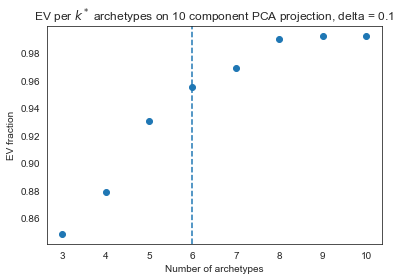

In [17]:
ev_per_arc = []
for i in range(3,11):
    XC, S, C, SSE, varexpl = PCHA(X_magic.obsm['X_pca'][:,0:7].T, noc=i, delta=0.1)
    ev_per_arc.append(varexpl)
    print(varexpl)
plt.scatter(x = [3,4,5,6,7,8,9,10], y = ev_per_arc)
plt.title(f"EV per $k^*$ archetypes on 10 component PCA projection, delta = 0.1")
plt.xlabel("Number of archetypes")
plt.ylabel("EV fraction")
print("Knee in EV vs k plot for different k_max:")
for kmax in range(8,11):
    print('k_max =', kmax)
    knee, farthestk = find_knee(ev_per_arc, kmax=kmax)
plt.axvline(x=knee, linestyle = "--")
plt.show()

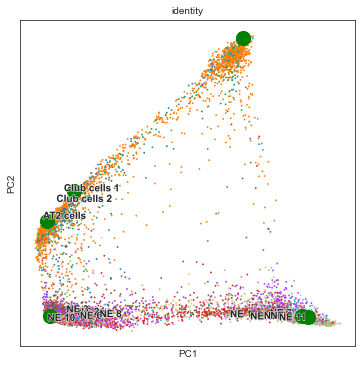

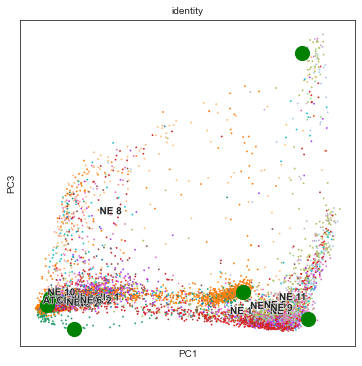

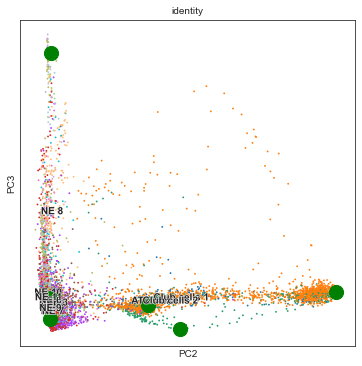

In [18]:
XC, S, C, SSE, varexpl = PCHA(X_magic.obsm['X_pca'][:,0:7].T, noc=6, delta=0)
XC = np.array(XC)
for components in ['1,2','1,3','2,3']:
    scv.pl.pca(X_magic, color = 'identity', components=components, show=False, figsize= (6,6), frameon=True)
    comp = components.split(',')
    plt.scatter(XC[int(comp[0])-1], XC[int(comp[1])-1], color = 'green', s = 200)
    plt.xlabel("PC"+comp[0])
    plt.ylabel("PC"+comp[1])

    plt.show()

In [22]:
# adata_U, umap = mb.pl.umap_update(adata, copy=True, method = "umap_original")

In [57]:
# XC_umap = umap.transform(XC.T).T


In [59]:
# sc.pl.scatter(adata_U, basis = 'umap_orig', color = "identity",show=False, frameon=True)
# plt.scatter(XC_umap[0], XC_umap[1], color = 'green', s = 200)
# plt.show()


## Labeling cells based on diffusion distance to archetypes
From Van Dijk et al:
An archetype is a weighted sum of cells, which allows us to construct archetypal-neighborhoods, consisting of cells most similar to the archetype. The neighborhoods are constructed by assigning cells to their nearest archetype based on the diffusion distance, as long as this distance is within a bounded proximity from the archetype. Diffusion distance is defined as the Euclidean distance on the diffusion map representation of the data, i.e., using diffusion components as a coordinate system (Nadler et al., 2006), denoted by DM(t).

In [19]:
XC_df = pd.DataFrame(XC)
XC_df.columns = ['Arc_1','Arc_2','Arc_3','Arc_4','Arc_5', "Arc_6"]


In [20]:
X_magic_pca_df = pd.DataFrame(X_magic.obsm['X_pca'][:,0:7], index = X_magic.obs_names)
X_magic_full_df = X_magic_pca_df.append(XC_df.T)
X_magic_full_df.head()

,0,1,2,3,4,5,6
gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1,-5.487069,-4.728208,-0.274789,-1.216845,0.464416,-1.073429,0.771162
gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1,-8.391650,-4.576259,-0.126386,-1.439424,1.067810,-0.600305,1.119351
gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1,-10.669321,4.233021,-0.441058,1.847779,-0.085097,0.160481,-2.313472
gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1,-9.421063,-4.166827,-0.503608,-1.019718,0.982071,-0.626454,0.927567
gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1,-8.642355,-4.448038,-0.539649,-1.668627,0.520869,-0.282774,1.005649


In [21]:
pdx = squareform(pdist(X_magic_full_df, metric='euclidean')) # compute distances on pca
pdx_df = pd.DataFrame(pdx, index=X_magic_full_df.index, columns=X_magic_full_df.index)
pdx_df = pdx_df.loc[XC_df.columns].drop(XC_df.columns, axis = 1)
X_magic.obsm['arc_distance'] = pdx_df.T

Now that we have a euclidean distance to each archetype on the MAGIC imputed data, we can find a neighborhood with arbritrary radius to classify cells closest to each archetype as specialists. In Van Dijk et al., they choose a radius (distance on diffusion map) that is 1/2 the minimum of the distance between archetypes.

In [22]:
pdx_archetypes = squareform(pdist(XC_df.T, metric='euclidean')) # compute distances on pca

radius = .5*pdx_archetypes[pdx_archetypes > 0].min()

In [23]:
tmp = X_magic.obsm['arc_distance'].copy()

In [24]:
# percent_radius = .1 # in percentage of datapoints; radius = .1 means 10% closest cells to each archetype

for arc in  X_magic.obsm['arc_distance'].columns:
    closest = X_magic.obsm['arc_distance'].loc[X_magic.obsm['arc_distance'][arc].sort_values() < radius]
    tmp.loc[closest.index,'specialist'] = arc


In [25]:
tmp.specialist

gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1      NaN
gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1    Arc_5
gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1    Arc_6
gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1    Arc_5
gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1    Arc_5
                                                ...  
gex_possorted_bam_1WGCZ:TTTGTGTTCCTTAGGGx-M2      NaN
gex_possorted_bam_1WGCZ:TTTGTGGCATGGCCCAx-M2    Arc_1
gex_possorted_bam_1WGCZ:TTTGTGTTCGGCCATAx-M2    Arc_1
gex_possorted_bam_1WGCZ:TTTGTTGGTCAAAGAAx-M2    Arc_1
gex_possorted_bam_1WGCZ:TTTGTGAAGTAAACCCx-M2    Arc_1
Name: specialist, Length: 8908, dtype: object

In [26]:
X_magic.obs['specialists_pca_diffdist'] = tmp.specialist

## Labeling by PCHA

<AxesSubplot:title={'center':'identity'}, xlabel='UMAP1', ylabel='UMAP2'>

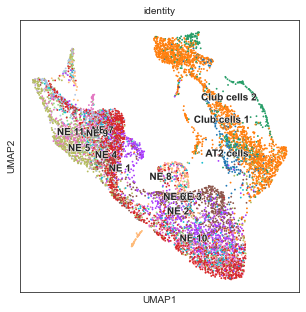

In [45]:
scv.pl.umap(X_magic, c = 'identity', components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu')


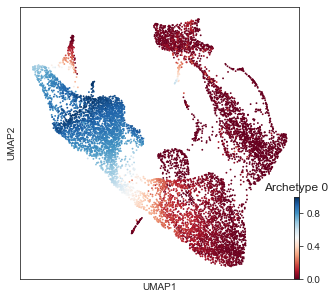

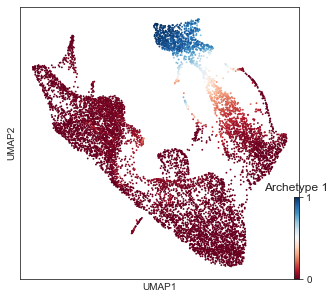

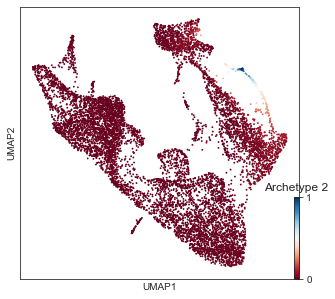

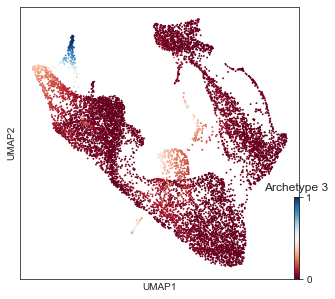

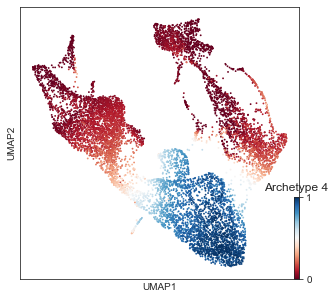

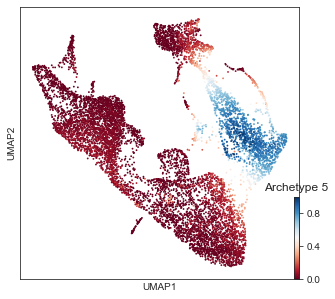

In [44]:
for i in range(6):
    scv.pl.umap(X_magic, c = [S[i,:].T], components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu')
    plt.title(f"Archetype {i}")
    # plt.savefig(f'./figures/unsupervised_AA_magic/{i}_scPCHA_pca.pdf')
    

In [29]:
S_df = pd.DataFrame(S.T)

In [30]:
S_df.index = X_magic.obs_names

In [31]:
X_magic.obsm['py_pcha_S'] = S.T

In [32]:
X_magic

AnnData object with n_obs × n_vars = 8908 × 16719
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'sample_x', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample_y', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_s

In [33]:
adata

AnnData object with n_obs × n_vars = 8908 × 16719
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'sample_x', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample_y', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_s

In [34]:
adata.obsm['arc_distance'] = pdx_df.T

In [35]:
S_df.columns = ['Arc_1','Arc_2','Arc_3','Arc_4','Arc_5', 'Arc_6']

In [36]:
adata.obsm['py_pcha_S'] = S_df

In [37]:
for c in adata.obsm['py_pcha_S']:
    adata.obs[f"{c}_PCHA_Score"] = adata.obsm['py_pcha_S'][c]

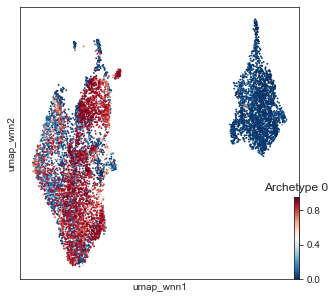

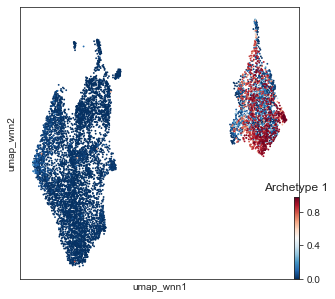

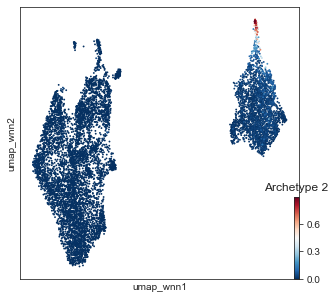

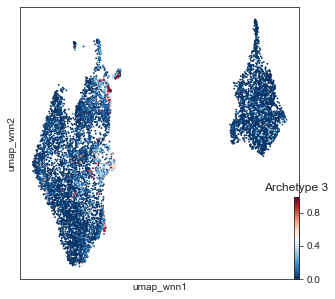

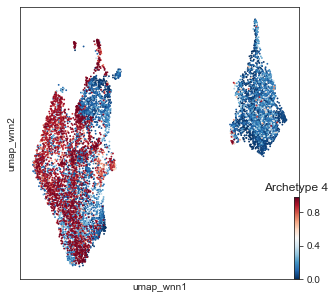

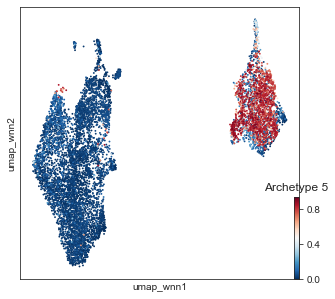

In [38]:
for i in range(6):
    scv.pl.scatter(adata, c = S[i,:].T, basis = "umap_wnn",components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu_r', smooth = True)
    plt.title(f"Archetype {i}")
    plt.show()

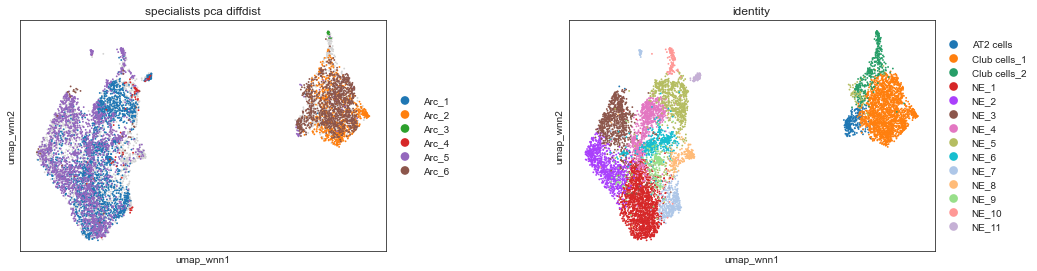

In [41]:
sc.pl.scatter(adata, basis = 'umap_wnn', color = ['specialists_pca_diffdist','identity'])

In [40]:
adata.obs

,dropkick_score,dropkick_label,arcsinh_n_genes_by_counts,sample_x,initial_size_spliced,initial_size_unspliced,initial_size,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,...,Phase,old.ident,wsnn_res.0.5,specialists_pca_diffdist,Arc_1_PCHA_Score,Arc_2_PCHA_Score,Arc_3_PCHA_Score,Arc_4_PCHA_Score,Arc_5_PCHA_Score,Arc_6_PCHA_Score
CellID,,,,,,,,,,,,,,,,,,,,,
gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1,0.190799,False,6.419998,M1,603,815,603.0,307,5.730100,603.0,...,G1,NE_5,1.0,NaN,0.208275,0.000000,0.000000,0.014635,0.777090,0.000000
gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1,0.270716,False,6.458341,M1,693,1079,693.0,319,5.768321,693.0,...,G1,NE_5,4.0,Arc_5,0.097748,0.000000,0.000000,0.009071,0.893181,0.000000
gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1,0.323707,False,6.100324,M1,487,551,487.0,223,5.411646,487.0,...,S,Club cells_1,0.0,Arc_6,0.000000,0.047739,0.011435,0.001306,0.098623,0.840897
gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1,0.193199,False,5.521477,M1,216,400,216.0,125,4.836282,216.0,...,S,NE_4,4.0,Arc_5,0.068632,0.000000,0.000000,0.000000,0.931368,0.000000
gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1,0.268449,False,6.342125,M1,608,1009,608.0,284,5.652489,608.0,...,G1,NE_2,2.0,Arc_5,0.098172,0.000000,0.000000,0.000000,0.901828,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gex_possorted_bam_1WGCZ:TTTGTGTTCCTTAGGGx-M2,0.000000,False,6.396932,M2,435,404,435.0,300,5.707110,435.0,...,G2M,NE_3,3.0,NaN,0.629433,0.000000,0.002559,0.000000,0.230872,0.137136
gex_possorted_bam_1WGCZ:TTTGTGGCATGGCCCAx-M2,0.377218,False,7.213769,M2,957,1898,957.0,679,6.522093,957.0,...,G1,NE_2,2.0,Arc_1,0.846308,0.050048,0.011704,0.000000,0.091940,0.000000
gex_possorted_bam_1WGCZ:TTTGTGTTCGGCCATAx-M2,0.336164,False,7.054450,M2,785,4144,785.0,579,6.363028,785.0,...,S,NE_1,2.0,Arc_1,0.865367,0.047096,0.000000,0.000000,0.084478,0.003060


# Write out data

In [42]:
adata.write_h5ad('../../data/combined/adata_02_filtered.h5ad')

In [43]:
X_magic.write_h5ad("../../data/combined/X_magic_02_filtered.h5ad")

## Write out data for ParetoTI 
T ratio calculation and comparison of single cell archetypes to bulk archetypes using enrichments


We will run archetype analysis using ParetoTI, and compare the single cell and bulk archetypes using the Hausser code (hypergeometric tests on enrichments). We will use the PCA of the MAGIC imputed data.

In [47]:
X_magic_for_R = X_magic.copy()

In [48]:
X_magic_for_R

AnnData object with n_obs × n_vars = 8908 × 16719
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'sample_x', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample_y', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_s

In [49]:
#Get rid of arc_distance, which causes a problem in R
X_magic_for_R.obsm = {'X_pca':X_magic_for_R.obsm['X_pca']}

In [50]:
# for col in ['specialists_pca_diffdist']:
#     X_magic_for_R.obs[col]=X_magic_for_R.obs[col].cat.add_categories("Unknown").fillna('Unknown')

In [51]:
X_magic_for_R.obs.isnull().values.any()

True

In [52]:
X_magic_for_R.obs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8908 entries, gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1 to gex_possorted_bam_1WGCZ:TTTGTGAAGTAAACCCx-M2
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   dropkick_score              8908 non-null   float64 
 1   dropkick_label              8908 non-null   category
 2   arcsinh_n_genes_by_counts   8908 non-null   float64 
 3   sample_x                    8908 non-null   category
 4   initial_size_spliced        8908 non-null   uint64  
 5   initial_size_unspliced      8908 non-null   uint64  
 6   initial_size                8908 non-null   float32 
 7   n_genes_by_counts           8908 non-null   int32   
 8   log1p_n_genes_by_counts     8908 non-null   float64 
 9   total_counts                8908 non-null   float32 
 10  log1p_total_counts          8908 non-null   float32 
 11  total_counts_mito           8908 non-null   float64 
 12

In [53]:
X_magic_for_R.write_h5ad("../../data/combined/X_magic_for_R_filtered.h5ad")


# Supervised AA

In [54]:
sig_matrix = pd.read_csv('/Users/smgroves/Documents/GitHub/Groves-CellSys2021/notebooks/out/bulk/sig_matrix_ParTI_2021.csv', header =0, index_col = 0)

sig_matrix = sig_matrix / np.linalg.norm(sig_matrix, axis=0)
sig_matrix.index = [i.capitalize() for i in sig_matrix.index]

If the below code gives an error about data shape, use `type = 'csr'`.

Cells with zero expression for all genes in gene signature will get scores of NaN when assigning scores in adata.obs (because these cells are filtered for the calculation). 

Trying to set attribute `.obs` of view, copying.


Transforming tumor data...
Gene signature matrix now has shape:  (79, 5)
Tumor data shortened to genes in gene list...
(7357, 79)
Tumor data subsetting complete.


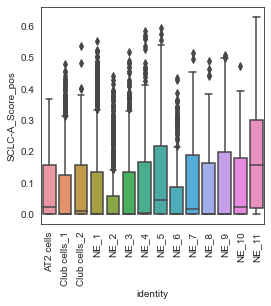

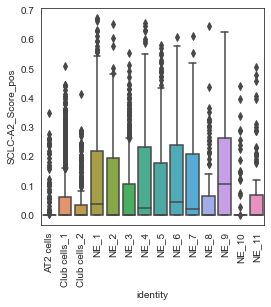

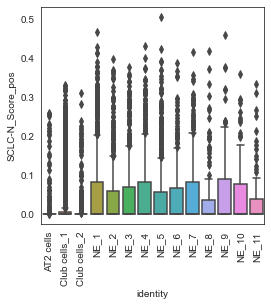

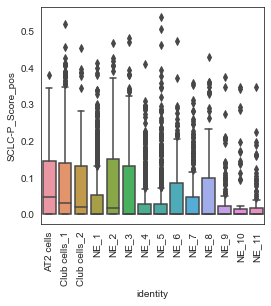

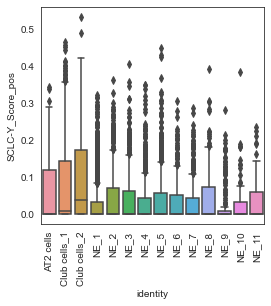

In [56]:
adata, adata_small, sig_matrix2 = mb.ar.phenotyping_recipe(adata, sig_matrix,groupby = 'identity',velocity=False)


In [ ]:
scv.pl.scatter(adata_small, color = [i for i in adata.obs.columns if i.endswith('_Score')], smooth = True, basis = 'umap_wnn', ncols = 6, cmap = 'rocket')

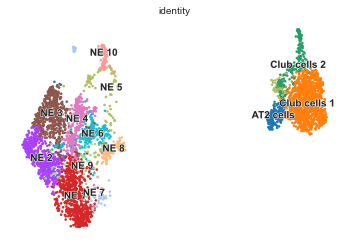

In [56]:
scv.pl.scatter(adata, color = 'identity', smooth = True, basis = 'umap_wnn')